In [238]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [3]:
# Load labor capacity data
ds_mean = xr.open_dataset('../data/processed/GFDL/labor_mean_ens1-3.nc').rename({'__xarray_dataarray_variable__':'capacity'})

In [199]:
# Population data
ds_pop = xr.open_dataset('../data/processed/GFDL/population_regrid_esm2m.nc')['population']
ds_pop = ds_pop.where(np.isfinite(ds_pop),0)
ds_pop = ds_pop.rename({'latitude':'lat','longitude':'lon'})

# Spatial Maps

## Setting up Plots: Daily Mean WBGT

In [373]:
# Function finds first year with labor capacity < threshold
def emergence(ds,thres=90,start_year=1950):
    # Array indices where capacity < threshold
    ds_thres = (ds<thres).nonzero()
    
    # If non-empty, index + startyear = ToE
    if len(ds_thres[0]) > 0:
        return start_year+(ds_thres[0][0].item())
    
    # If empty, return absurdly high value
    return 3000

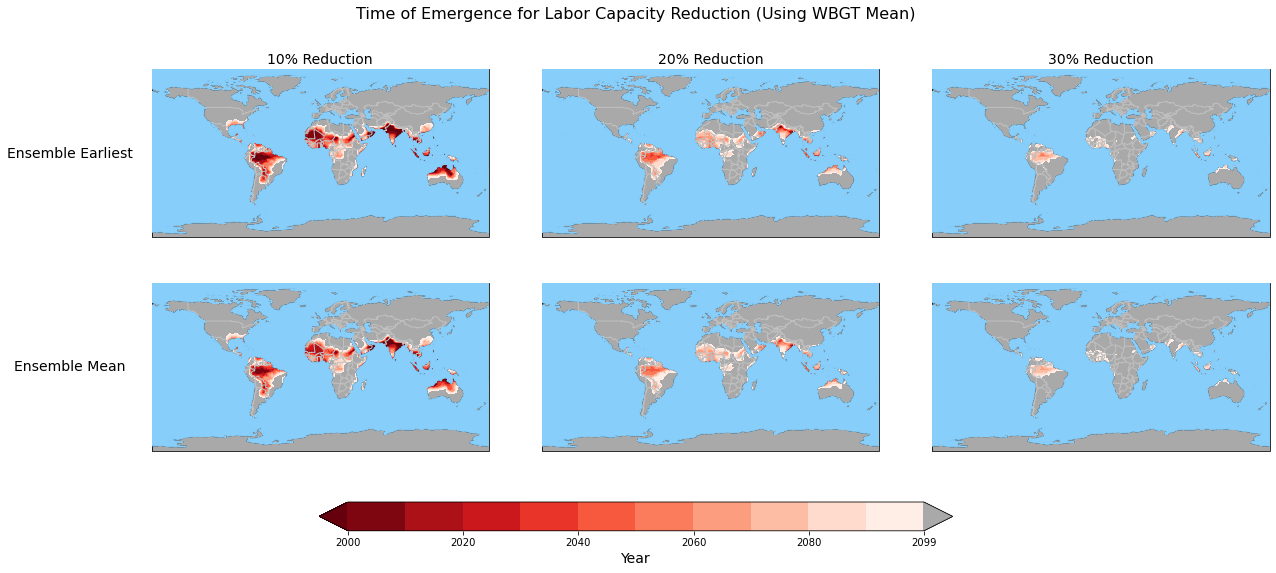

In [384]:
lf.spatial_toe(ds_mean['capacity'],'Time of Emergence for Labor Capacity Reduction (Using WBGT Mean)')
plt.savefig('toe_mean_map.png')

## Setting up Plots: Daily Max WBGT

In [180]:
# Load labor capacity data
ds_max = xr.open_dataset('../data/processed/GFDL/labor_max_ens1-3.nc').rename({'__xarray_dataarray_variable__':'capacity'})

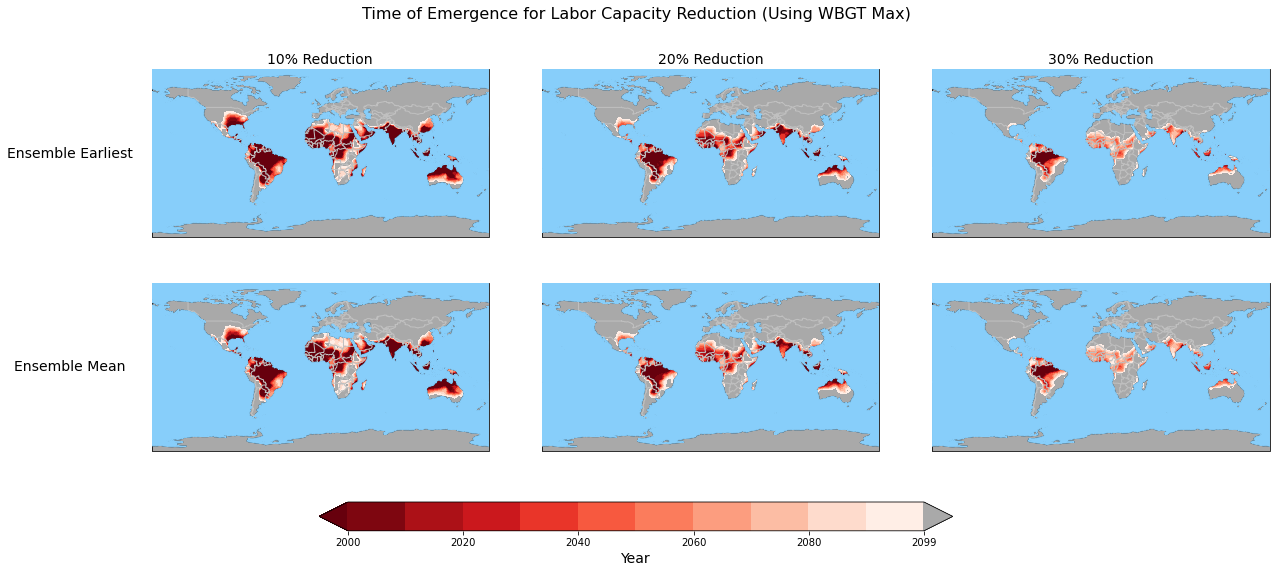

In [386]:
lf.spatial_toe(ds_max['capacity'],'Time of Emergence for Labor Capacity Reduction (Using WBGT Max)')
plt.savefig('toe_max_map.png')

# Bar Charts: Average ToE

## Daily Mean WBGT

In [353]:
# Calculate # of >ToE years for different thresholds
ds_90 = xr.apply_ufunc(lf.thres_years,ds_mean['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':90})
ds_80 = xr.apply_ufunc(lf.thres_years,ds_mean['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':80})
ds_70 = xr.apply_ufunc(lf.thres_years,ds_mean['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':70})

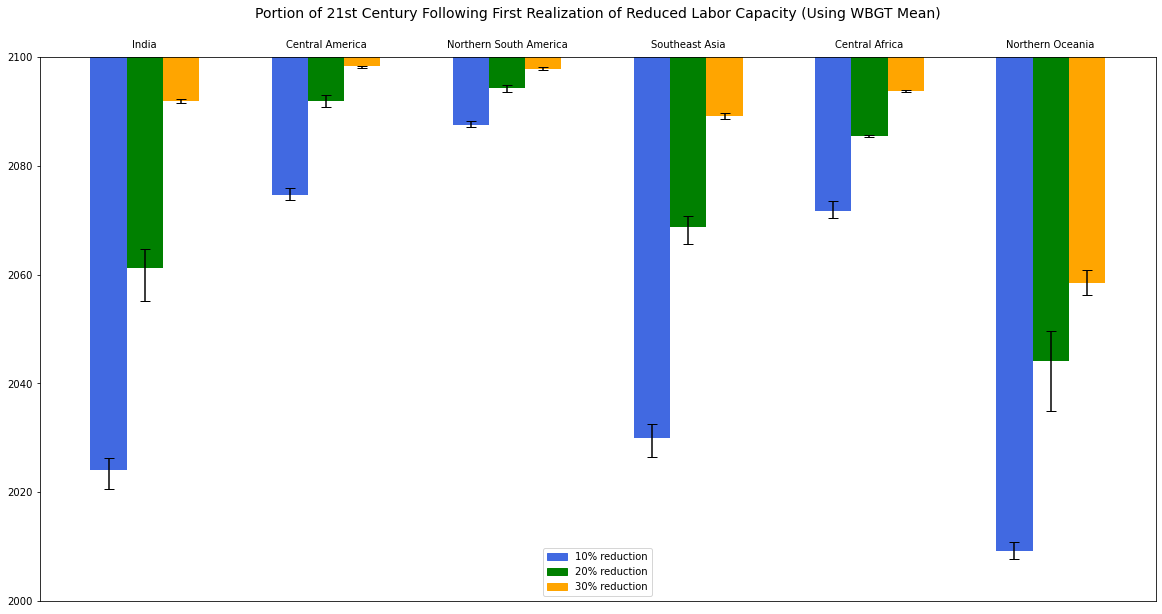

In [355]:
# Regions to plot
regions = ['India','Central America','Northern South America','Southeast Asia','Central Africa','Northern Oceania']

fig, ax = plt.subplots(figsize=(20,10))

# Location of region labels; width of bars
locs = np.arange(len(regions))
width = 0.2

for x in locs:
    region = regions[x]
    # Get number of >ToE years for grid cells in region
    ds_90_region = lf.slice_region(ds_90,region,'GFDL')
    ds_80_region = lf.slice_region(ds_80,region,'GFDL')
    ds_70_region = lf.slice_region(ds_70,region,'GFDL')
    pop_region = lf.slice_region(ds_pop,region,'GFDL')
    
    # Population-weighted average number of >ToE years
    years_90 = ds_90_region.weighted(pop_region).mean(['lon','lat'])
    years_80 = ds_80_region.weighted(pop_region).mean(['lon','lat'])
    years_70 = ds_70_region.weighted(pop_region).mean(['lon','lat'])
    
    # [[Lower range],[upper range]] -- range of values across ensemble members
    errors_90 = [[years_90.max('ensemble')-years_90.mean('ensemble')],[years_90.mean('ensemble')-years_90.min('ensemble')]]
    ax.bar(x - width, -years_90.mean('ensemble'), width, label='10%', bottom=2100, yerr=errors_90, error_kw={'capsize':5}, color='royalblue')
    errors_80 = [[years_80.max('ensemble')-years_80.mean('ensemble')],[years_80.mean('ensemble')-years_80.min('ensemble')]]
    ax.bar(x, -years_80.mean('ensemble'), width, label='20%', bottom=2100, yerr=errors_80, error_kw={'capsize':5}, color='green')
    errors_70 = [[years_70.max('ensemble')-years_70.mean('ensemble')],[years_70.mean('ensemble')-years_70.min('ensemble')]]
    ax.bar(x + width, -years_70.mean('ensemble'), width, label='30%',bottom=2100, yerr=errors_70, error_kw={'capsize':5}, color='orange')

# Region labels on top
ax.xaxis.set_tick_params(labeltop=True,labelbottom=False,bottom=False)
ax.set_xticks(locs)
ax.set_xticklabels(regions)
ax.set_ylim([2000,2100]);

# Legend for different thresholds
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='green', label='20% reduction')
orange_patch = mpatches.Patch(color='orange', label='30% reduction')
ax.legend(handles=[blue_patch,green_patch,orange_patch], loc='lower center');
ax.set_title('Portion of 21st Century Following First Realization of Reduced Labor Capacity (Using WBGT Mean)\n',fontsize=14);
#fig.savefig('toe_mean_bar.png')

## Daily Max WBGT

In [269]:
# Calculate # of >ToE years for different thresholds
ds_90_max = xr.apply_ufunc(lf.thres_years,ds_max['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':90})
ds_80_max = xr.apply_ufunc(lf.thres_years,ds_max['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':80})
ds_70_max = xr.apply_ufunc(lf.thres_years,ds_max['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':70})

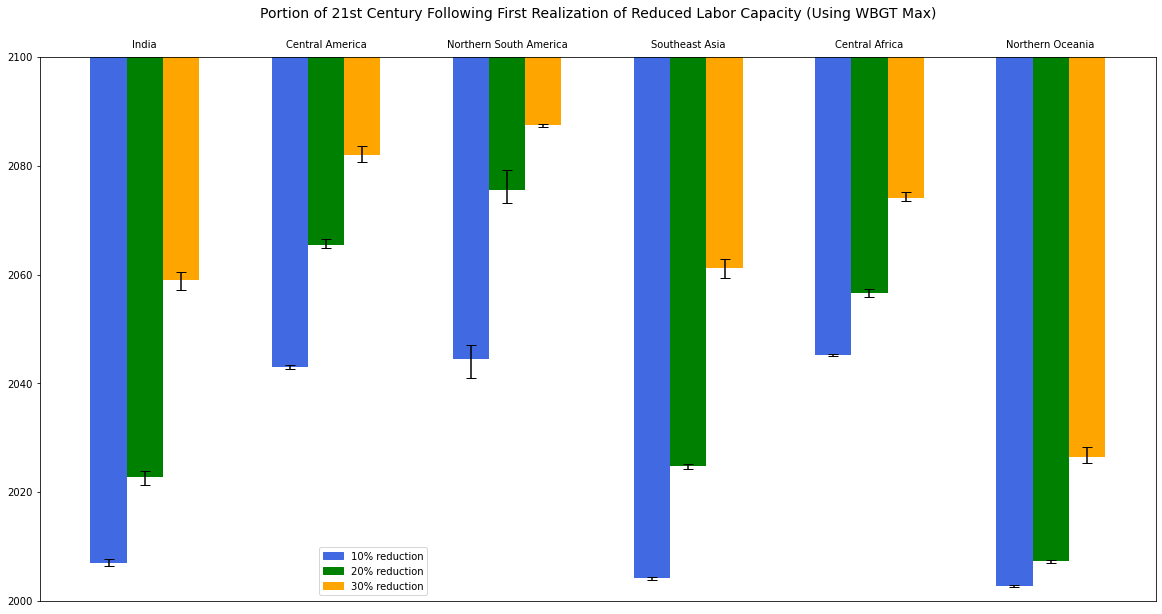

In [324]:
# Regions to plot
regions = ['India','Central America','Northern South America','Southeast Asia','Central Africa','Northern Oceania']

fig, ax = plt.subplots(figsize=(20,10))
# Location of region labels; width of bars
locs = np.arange(len(regions))
width = 0.2

for x in locs:
    region = regions[x]
    # Get number of >ToE years for grid cells in region
    ds_90_region = lf.slice_region(ds_90_max,region,'GFDL')
    ds_80_region = lf.slice_region(ds_80_max,region,'GFDL')
    ds_70_region = lf.slice_region(ds_70_max,region,'GFDL')
    pop_region = lf.slice_region(ds_pop,region,'GFDL')

    # Population-weighted average number of >ToE years
    years_90 = ds_90_region.weighted(pop_region).mean(['lon','lat'])
    years_80 = ds_80_region.weighted(pop_region).mean(['lon','lat'])
    years_70 = ds_70_region.weighted(pop_region).mean(['lon','lat'])
    
    # [[Lower range],[upper range]] -- range of values across ensemble members
    errors_90 = [[years_90.max('ensemble')-years_90.mean('ensemble')],[years_90.mean('ensemble')-years_90.min('ensemble')]]
    ax.bar(x - width, -years_90.mean('ensemble'), width, label='10%', bottom=2100, yerr=errors_90, error_kw={'capsize':5}, color='royalblue')
    errors_80 = [[years_80.max('ensemble')-years_80.mean('ensemble')],[years_80.mean('ensemble')-years_80.min('ensemble')]]
    ax.bar(x, -years_80.mean('ensemble'), width, label='20%', bottom=2100, yerr=errors_80, error_kw={'capsize':5}, color='green')
    errors_70 = [[years_70.max('ensemble')-years_70.mean('ensemble')],[years_70.mean('ensemble')-years_70.min('ensemble')]]
    ax.bar(x + width, -years_70.mean('ensemble'), width, label='30%',bottom=2100, yerr=errors_70, error_kw={'capsize':5}, color='orange')

# Region labels on top
ax.xaxis.set_tick_params(labeltop=True,labelbottom=False,bottom=False)
ax.set_xticks(locs)
ax.set_xticklabels(regions)
ax.set_ylim([2000,2100]);

# Legend for different thresholds
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='green', label='20% reduction')
orange_patch = mpatches.Patch(color='orange', label='30% reduction')
ax.legend(handles=[blue_patch,green_patch,orange_patch], loc=(0.25,0.01));
ax.set_title('Portion of 21st Century Following First Realization of Reduced Labor Capacity (Using WBGT Max)\n',fontsize=14);
fig.savefig('toe_max_bar.png')

# Bar Charts: ToE of Average

## Daily Mean WBGT

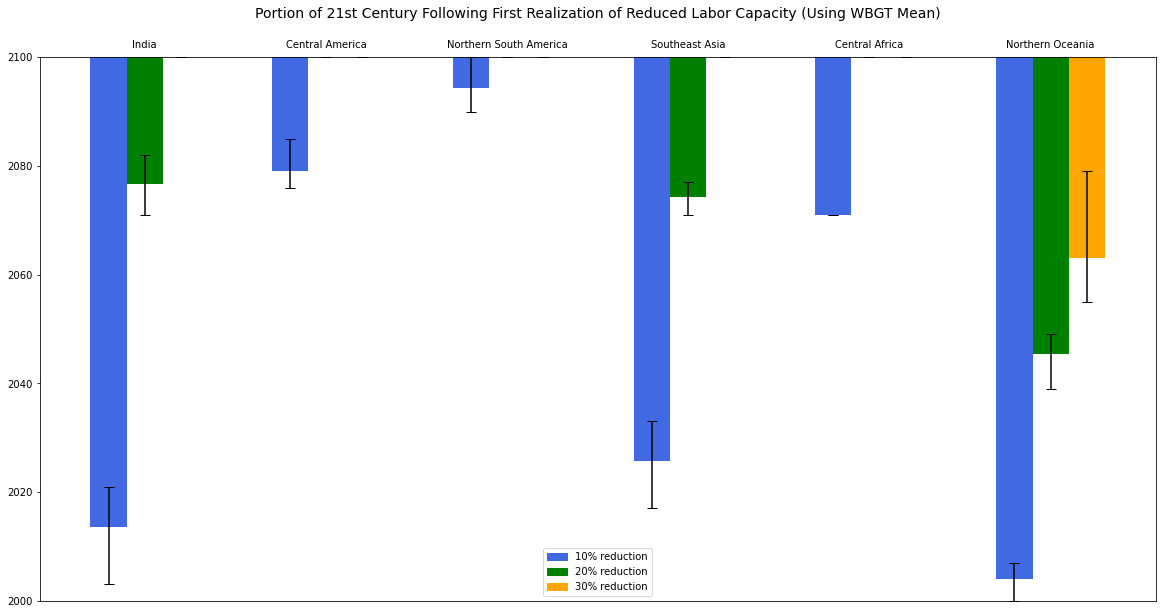

In [329]:
# Regions to plot
regions = ['India','Central America','Northern South America','Southeast Asia','Central Africa','Northern Oceania']

fig, ax = plt.subplots(figsize=(20,10))

# Location of region labels; width of bars
locs = np.arange(len(regions))
width = 0.2

for x in locs:
    region = regions[x]
    
    # Population-weighted regional labor capacity
    ds_region = lf.slice_region(ds_mean,region,'GFDL')
    pop_region = lf.slice_region(ds_pop,region,'GFDL')
    capacity = ds_region.weighted(pop_region).mean(['lat','lon'])

    # Number of >ToE years using regional average
    years_90 = xr.apply_ufunc(lf.thres_years,capacity['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':90})
    years_80 = xr.apply_ufunc(lf.thres_years,capacity['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':80})
    years_70 = xr.apply_ufunc(lf.thres_years,capacity['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':70})
    
    # [[Lower range],[upper range]] -- range of values across ensemble members
    errors_90 = [[years_90.max('ensemble')-years_90.mean('ensemble')],[years_90.mean('ensemble')-years_90.min('ensemble')]]
    ax.bar(x - width, -years_90.mean('ensemble'), width, label='10%', bottom=2100, yerr=errors_90, error_kw={'capsize':5}, color='royalblue')
    errors_80 = [[years_80.max('ensemble')-years_80.mean('ensemble')],[years_80.mean('ensemble')-years_80.min('ensemble')]]
    ax.bar(x, -years_80.mean('ensemble'), width, label='20%', bottom=2100, yerr=errors_80, error_kw={'capsize':5}, color='green')
    errors_70 = [[years_70.max('ensemble')-years_70.mean('ensemble')],[years_70.mean('ensemble')-years_70.min('ensemble')]]
    ax.bar(x + width, -years_70.mean('ensemble'), width, label='30%',bottom=2100, yerr=errors_70, error_kw={'capsize':5}, color='orange')

# Region labels on top
ax.xaxis.set_tick_params(labeltop=True,labelbottom=False,bottom=False)
ax.set_xticks(locs)
ax.set_xticklabels(regions)
ax.set_ylim([2000,2100]);

# Legend for different thresholds
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='green', label='20% reduction')
orange_patch = mpatches.Patch(color='orange', label='30% reduction')
ax.legend(handles=[blue_patch,green_patch,orange_patch], loc='lower center');
ax.set_title('Portion of 21st Century Following First Realization of Reduced Labor Capacity (Using WBGT Mean)\n',fontsize=14);
fig.savefig('toe_mean_bar2.png')

# Daily Max WBGT

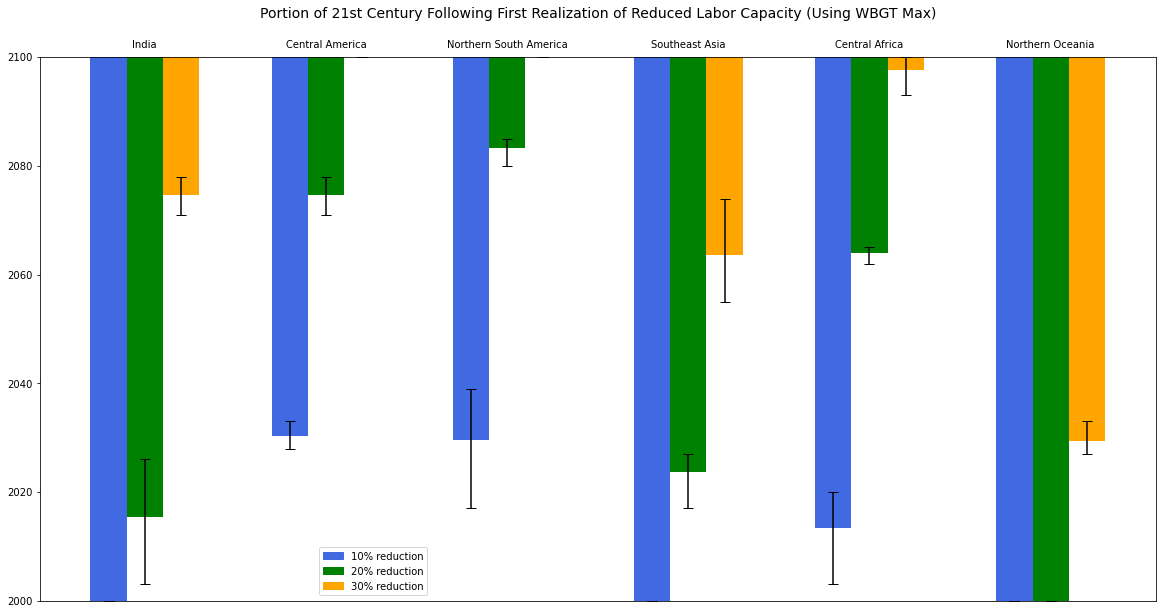

In [330]:
# Regions to plot
regions = ['India','Central America','Northern South America','Southeast Asia','Central Africa','Northern Oceania']

fig, ax = plt.subplots(figsize=(20,10))

# Location of region labels; width of bars
locs = np.arange(len(regions))
width = 0.2

for x in locs:
    region = regions[x]
    
    # Population-weighted regional labor capacity
    ds_region = lf.slice_region(ds_max,region,'GFDL')
    pop_region = lf.slice_region(ds_pop,region,'GFDL')
    capacity = ds_region.weighted(pop_region).mean(['lat','lon'])

    # Number of >ToE years using regional average
    years_90 = xr.apply_ufunc(lf.thres_years,capacity['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':90})
    years_80 = xr.apply_ufunc(lf.thres_years,capacity['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':80})
    years_70 = xr.apply_ufunc(lf.thres_years,capacity['capacity'],input_core_dims=[['time']],vectorize=True,kwargs={'thres':70})
    
    # [[Lower range],[upper range]] -- range of values across ensemble members
    errors_90 = [[years_90.max('ensemble')-years_90.mean('ensemble')],[years_90.mean('ensemble')-years_90.min('ensemble')]]
    ax.bar(x - width, -years_90.mean('ensemble'), width, label='10%', bottom=2100, yerr=errors_90, error_kw={'capsize':5}, color='royalblue')
    errors_80 = [[years_80.max('ensemble')-years_80.mean('ensemble')],[years_80.mean('ensemble')-years_80.min('ensemble')]]
    ax.bar(x, -years_80.mean('ensemble'), width, label='20%', bottom=2100, yerr=errors_80, error_kw={'capsize':5}, color='green')
    errors_70 = [[years_70.max('ensemble')-years_70.mean('ensemble')],[years_70.mean('ensemble')-years_70.min('ensemble')]]
    ax.bar(x + width, -years_70.mean('ensemble'), width, label='30%',bottom=2100, yerr=errors_70, error_kw={'capsize':5}, color='orange')

# Region labels on top
ax.xaxis.set_tick_params(labeltop=True,labelbottom=False,bottom=False)
ax.set_xticks(locs)
ax.set_xticklabels(regions)
ax.set_ylim([2000,2100]);

# Legend for different thresholds
blue_patch = mpatches.Patch(color='royalblue', label='10% reduction')
green_patch = mpatches.Patch(color='green', label='20% reduction')
orange_patch = mpatches.Patch(color='orange', label='30% reduction')
ax.legend(handles=[blue_patch,green_patch,orange_patch], loc=(0.25,0.01));
ax.set_title('Portion of 21st Century Following First Realization of Reduced Labor Capacity (Using WBGT Max)\n',fontsize=14);
fig.savefig('toe_max_bar2.png')